# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
data = np.genfromtxt('/content/drive/MyDrive/AI/TP6/data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [ ]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [ ]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

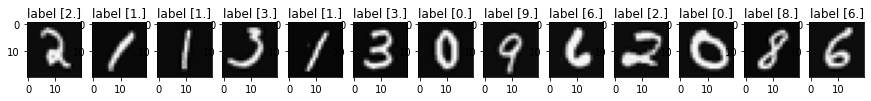

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [ ]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [ ]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [ ]:
# poids de la couche 1
W1 = np.genfromtxt('/content/drive/MyDrive/AI/TP6/W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [ ]:
# poids de la couche 2
W2 = np.genfromtxt('/content/drive/MyDrive/AI/TP6/W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [ ]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

In [ ]:
def computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_=0):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    z2=np.column_stack((np.ones((X.shape[0],1)), (a1 @ theta1.T)))
    a2=Sigmoid(z2)
    a2[:,0] = 1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=(a2 @ theta2.T)
    a3=Sigmoid(z3)

    J = np.zeros((YY.shape[0],1))
    J = (1/y.shape[0]) *(np.sum(np.sum((-YY * np.log(a3)) - ((1 - YY) * np.log(1 - a3))))) + (lambda_ / (2 * X.shape[0])) * ((theta1[:, 1:] ** 2).sum() + (theta2[:, 1:] ** 2).sum())
        

    return J

In [ ]:
computeCost(X, YY, W1, W2,hidden_layer_size, 0)

10.441433938769038

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [ ]:
def NNCostFunction(X, YY, theta1, theta2, lambda_=0):
    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta1.shape[0],theta1.shape[1]))

    out1= Sigmoid(X @ theta1.T)
    
    intercept=np.ones((out1.shape[0],1))
    out1=np.column_stack((intercept,out1))
    
    out2 = out1@theta2.T
    
    out3 = Sigmoid(out2)
    J= (np.sum(((-YY*np.log(out3))-(1-YY)*np.log(1-out3) ))/(YY.shape[0])) +lambda_*((theta1**2).sum()+(theta2**2).sum() )/(2*YY.shape[0])
    out4 = (out3-YY)/YY.shape[0]

    theta2_grad = (out4.T @out1)
    out5 = (out4@theta2) * (out1* (1-out1)) 

    theta1_grad = (out5.T @ X)
    thetaa1 = theta1_grad[1:]+ (lambda_/YY.shape[0])*theta1
    thetaa2 = theta2_grad + (lambda_/YY.shape[0]) * theta2

    return J, [thetaa1, thetaa2]

In [ ]:
cost, theta = NNCostFunction(X, YY, W1, W2,1)
cost

10.538292383435762

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


Etant donnée la taille du dataset (5000 samples) on a décidé d'appliquer un split, d'une part pour pouvoir écourter le temps d'entrainement, d'autre part pour pouvoir bien vérifier les performence du modèle (overfitting/underfitting).
 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, YY, test_size=0.8)

In [ ]:
def gradientDescent(X_train, y_train , X_test , y_test, theta, alpha, iterations, lambda_=0):
    costTrain = []
    costTest = []

    for i in tqdm(range(iterations)):
      cost, thetaa = NNCostFunction(X_train, y_train, theta[0] , theta[1], lambda_)
      costTrain.append(cost)

      theta[0] = theta[0] - alpha * thetaa[0]
      theta[1] = theta[1] - alpha * thetaa[1]

      cost_reg, _ = NNCostFunction(X_test, y_test, theta[0] , theta[1], lambda_)
      costTest.append(cost_reg)

    return theta, np.asarray(costTrain), np.asarray(costTest)

In [ ]:
iterations = 500
alpha = 1.3
# He-et-al Initialization
theta1 = [np.random.randn(hidden_layer_size, input_layer_size+1)*np.sqrt(2/input_layer_size), np.random.randn(10, hidden_layer_size+1)*np.sqrt(2/input_layer_size)]

theta, trainCost, testCost = gradientDescent(X_train, y_train , X_test , y_test, theta1, alpha, iterations)


100%|██████████| 500/500 [00:16<00:00, 29.58it/s]


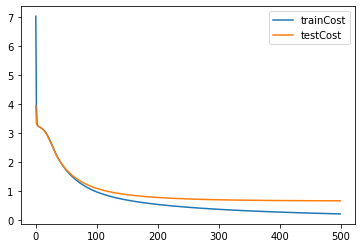

In [ ]:
plt.plot(range(iterations), trainCost, label='trainCost')
plt.plot(range(iterations), testCost, label='testCost')
plt.legend()
plt.show()

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [ ]:
iterations = 500
alpha = 1.3
# He-et-al Initialization
theta2 = [np.random.randn(hidden_layer_size, input_layer_size+1)*np.sqrt(2/input_layer_size), np.random.randn(10, hidden_layer_size+1)*np.sqrt(2/input_layer_size)]

theta_reg, trainCost_reg, testCost_reg = gradientDescent(X_train, y_train , X_test , y_test, theta2, alpha, iterations, lambda_=0.5)

100%|██████████| 500/500 [00:16<00:00, 30.00it/s]


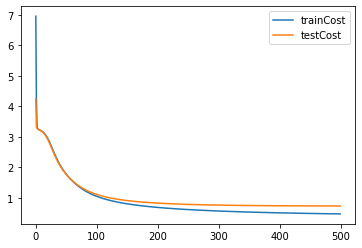

In [ ]:
plt.plot(range(iterations), trainCost_reg, label='trainCost')
plt.plot(range(iterations), testCost_reg, label='testCost')
plt.legend()
plt.show()

In [ ]:
computeCost(X, YY, theta[0], theta[1],hidden_layer_size, 0), computeCost(X, YY, theta_reg[0], theta_reg[1],hidden_layer_size, 1)

(0.5716275755176479, 0.6778949917161481)

On remarque qu'en utilisant la régularisation, le train et test sets converge plus rapidement, contrairement à sans la régularisation ou les 2 coubes semble diverger

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [ ]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie

    out1 = Sigmoid(X @ W1.T)
    
    intercept = np.ones((X.shape[0],1))
    inp = np.column_stack((intercept, out1))
    
    out2 = Sigmoid(inp @ W2.T)
    
    y_pred = np.argmax(out2, axis=1)[..., np.newaxis]


    return y_pred

In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(theta[0], theta[1], X)
precision = np.mean(y==y_pred)*100
precision

91.28

In [ ]:
y_pred=predict(theta_reg[0], theta_reg[1], X)
precision = np.mean(y==y_pred)*100
precision

91.25999999999999

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(25, ), max_iter = 5000, activation = 'logistic', solver = 'sgd')

In [ ]:
mlp.fit(X[:, 1:], YY)

MLPClassifier(activation='logistic', hidden_layer_sizes=(25,), max_iter=5000,
              solver='sgd')

In [ ]:
y_pred = np.argmax(mlp.predict(X[:, 1:]), axis=1)[..., np.newaxis]
precision = np.mean(y==y_pred)*100
precision

90.78

In [ ]:
mlp.score(X[:, 1:], YY) * 100

90.03999999999999

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

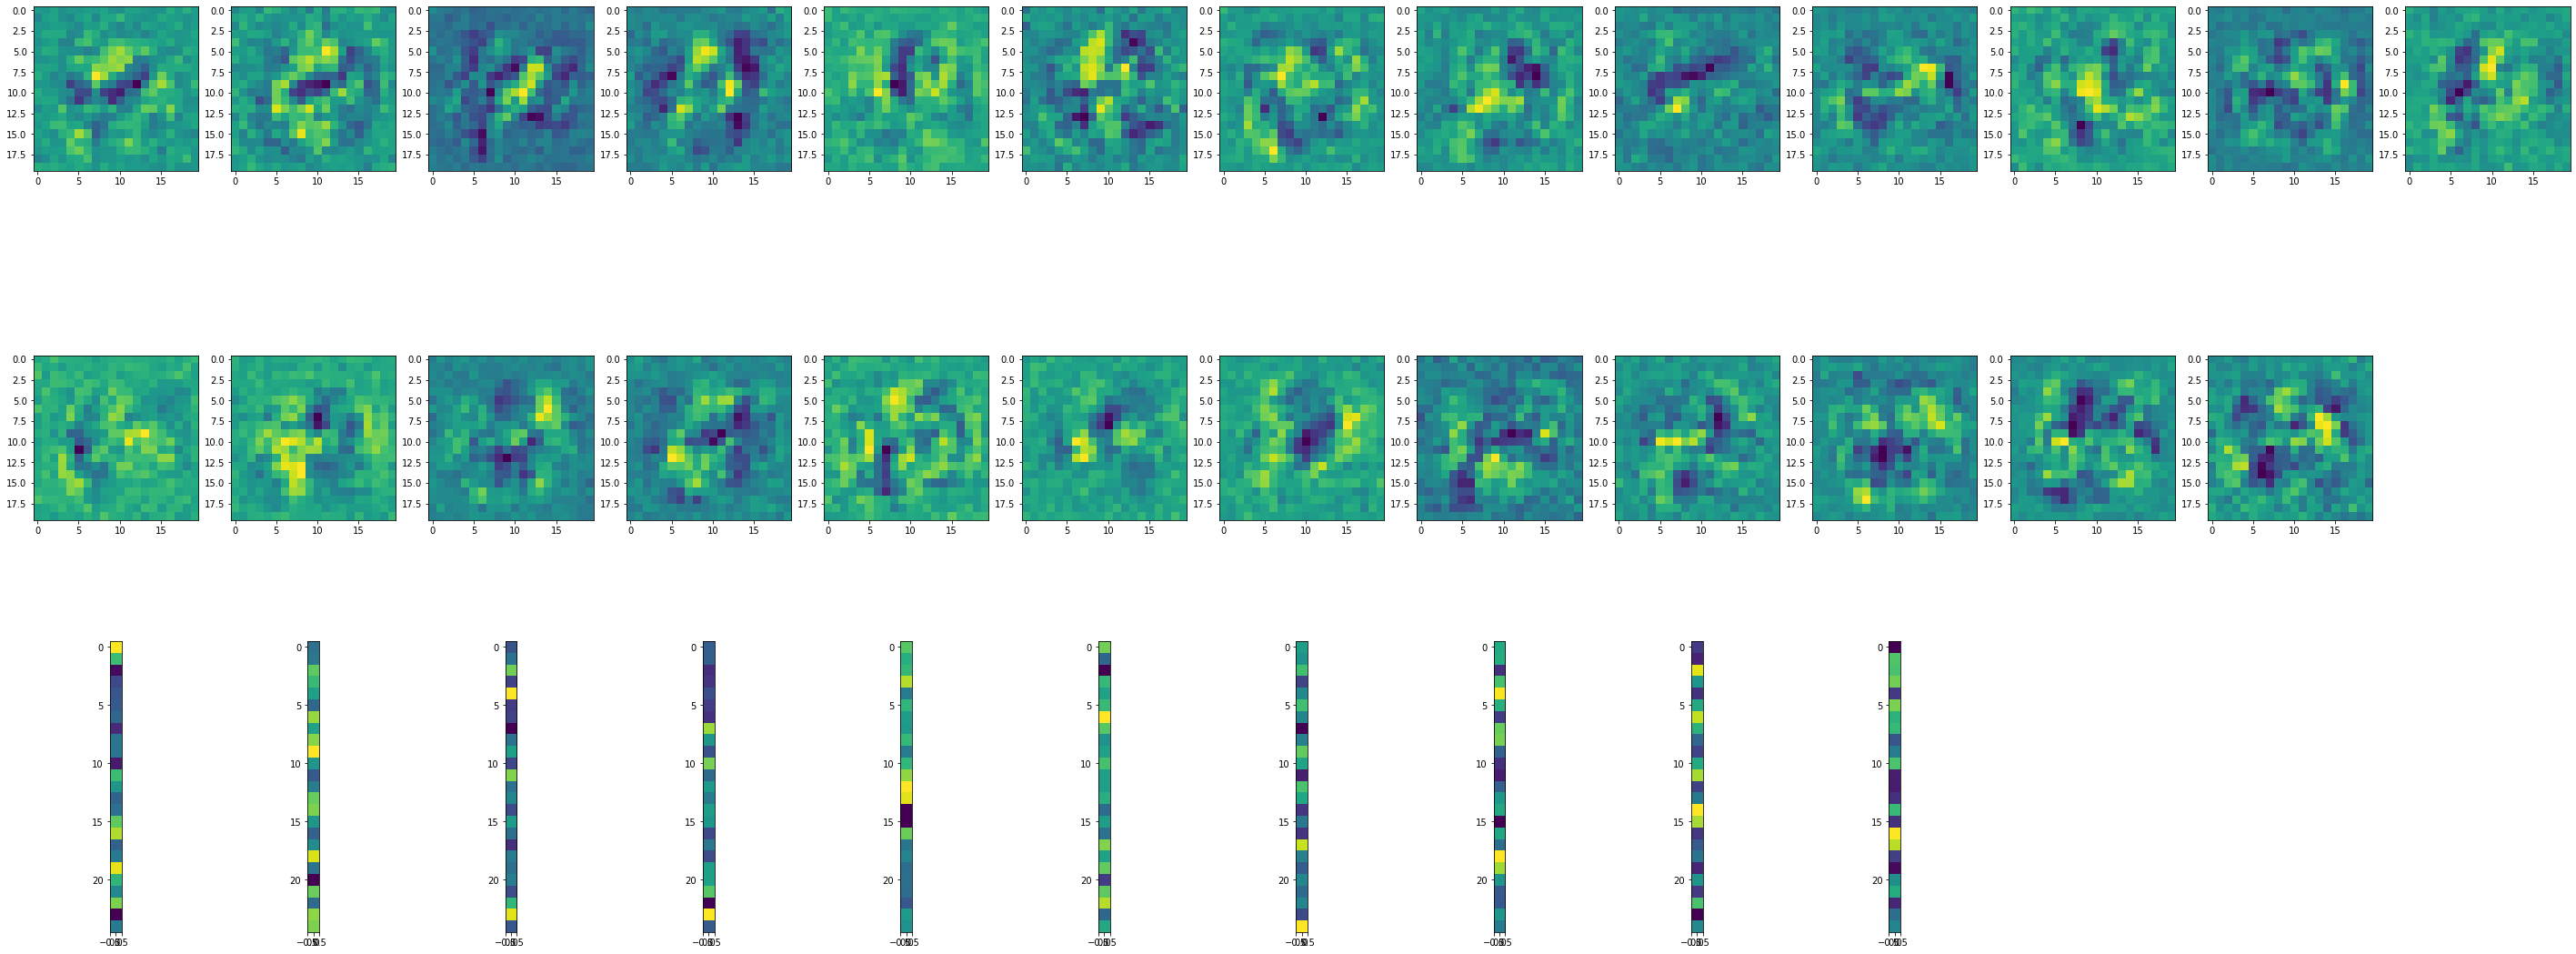

In [ ]:
plt.figure(figsize=(50, 20))
for i in range(theta[0].shape[0]):
  plt.subplot(3, 13, i + 1)
  plt.imshow(np.reshape(theta[0][i][1:], (20, 20)))
for i in range(theta[1].shape[0]):
  plt.subplot(3, 13, theta[0].shape[0] + i + 2)
  plt.imshow(np.reshape(theta[1][i][1:], (-1, 1)))

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [ ]:
# bonne chance